# Importing packages

In [2]:
# libraries
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import pickle
import os
import time

In [3]:
# Sklearn

# Estimators
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


# Others
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.metrics import r2_score

# Defining functions to use in the future

### Plotting

In [4]:
# Plot how does n of estimators affect the prediction metrics

def plot_n_estimators_effect(clf, X, y, X_test, y_test, n_estimators_range):
    train_accuracy_list = []
    train_precision_list = []
    train_recall_list = []
    val_accuracy_list = []
    val_precision_list = []
    val_recall_list = []
    test_accuracy_list = []
    test_precision_list = []
    test_recall_list = []
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    for n_estimators in n_estimators_range:
        forest_clf = clf
        clf.n_estimators = n_estimators
        forest_clf.fit(X_train, y_train)
        y_hat_train = forest_clf.predict(X_train)
        y_hat_val = forest_clf.predict(X_val)
        y_hat_test = forest_clf.predict(X_test)
        train_accuracy_list.append(accuracy_score(y_train, y_hat_train))
        train_precision_list.append(precision_score(y_train, y_hat_train))
        train_recall_list.append(recall_score(y_train, y_hat_train))
        val_accuracy_list.append(accuracy_score(y_val, y_hat_val))
        val_precision_list.append(precision_score(y_val, y_hat_val))
        val_recall_list.append(recall_score(y_val, y_hat_val))
        test_accuracy_list.append(accuracy_score(y_test, y_hat_test))
        test_precision_list.append(precision_score(y_test, y_hat_test))
        test_recall_list.append(recall_score(y_test, y_hat_test))
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(n_estimators_range, train_accuracy_list, label="Train_accuracy", marker="s", linewidth=3)
    ax.plot(n_estimators_range, train_precision_list, label="Train_precision", marker="s", linewidth=3)
    ax.plot(n_estimators_range, train_recall_list, label="Train_recall", marker="s", linewidth=3)
    ax.plot(n_estimators_range, val_accuracy_list, label="Val_accuracy", marker="o", linewidth=5)
    ax.plot(n_estimators_range, val_precision_list, label="Val_precision", marker="o", linewidth=5)
    ax.plot(n_estimators_range, val_recall_list, label="Val_recall", marker="o", linewidth=5)
    ax.plot(n_estimators_range, test_accuracy_list, label="Test_accuracy", marker="x", linewidth=7)
    ax.plot(n_estimators_range, test_precision_list, label="Test_precision", marker="x", linewidth=7)
    ax.plot(n_estimators_range, test_recall_list, label="Test_recall", marker="x", linewidth=7)

    ax.legend()
    # plt.savefig("Metrix.png", dpi=1000)

In [5]:
# Plot correlation matrix

def plot_corr_heat_map(df):
    corr_matrix = df.corr().abs()
    figure, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
    return ax

In [6]:
# Plot how does the amount of data used in training affect the prediction metrics

def plot_data_amount_tendency_reg(model, X_train, y_train, X_test, y_test, step):
    data_length = len(X_train)
    start_point = data_length - step * (data_length//step)
    data_length_list = []
    train_r2_list = []
    test_r2_list = []

    for data_len in range(start_point, data_length + 1, step):
        try:
            print("Current_data_lenth: {}".format(data_len))
            # Параметры лучшего классификатора из grid_search
            current_model = model
            learning_chunk = X_train[:data_len]
            target_chunk = y_train[:data_len]
            current_model.fit(learning_chunk, target_chunk)

            y_hat_train = current_model.predict(learning_chunk)
            y_hat_test = current_model.predict(X_test)
            data_length_list.append(data_len)

            train_r2_list.append(r2_score(target_chunk , y_hat_train))
            test_r2_list.append(r2_score(y_test, y_hat_test))

            
        except ValueError:
            continue
        
    fig, ax = plt.subplots(figsize=(10, 10))
    
    ax.plot(data_length_list, train_r2_list, label="Train_R2", marker="s", linewidth=3)
    ax.plot(data_length_list, test_r2_list, label="Test_R2", marker="x", linewidth=5)
    ax.set_xlabel("Amount_of_training_data")
    ax.set_ylabel("R2_metric")
    ax.legend()

In [7]:
# Plot how does the amount of data used in training affect the prediction metrics

def plot_data_amount_tendency_clf(model, X_train, y_train, X_test, y_test, step):
    data_length = len(X_train)
    start_point = data_length - step * (data_length//step)
    data_length_list = []
    train_accuracy_list = []
    train_precision_list = []
    train_recall_list = []
    test_accuracy_list = []
    test_precision_list = []
    test_recall_list = []
    for data_len in range(start_point, data_length + 1, step):
        try:
            print("Current_data_lenth: {}".format(data_len))
            # Параметры лучшего классификатора из grid_search
            current_model = model
            learning_chunk = X_train[:data_len]
            target_chunk = y_train[:data_len]
            current_model.fit(learning_chunk, target_chunk)

            y_hat_train = current_model.predict(learning_chunk)
            y_hat_test = current_model.predict(X_test)
            data_length_list.append(data_len)

            train_accuracy_list.append(accuracy_score(target_chunk , y_hat_train))
            train_precision_list.append(precision_score(target_chunk , y_hat_train))
            train_recall_list.append(recall_score(target_chunk , y_hat_train))

            test_accuracy_list.append(accuracy_score(y_test, y_hat_test))
            test_precision_list.append(precision_score(y_test, y_hat_test))
            test_recall_list.append(recall_score(y_test, y_hat_test))
        except ValueError:
            continue
        
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(data_length_list, train_accuracy_list, label="Train_accuracy", marker="s", linewidth=3)
    ax.plot(data_length_list, train_precision_list, label="Train_precision", marker="s", linewidth=3)
    ax.plot(data_length_list, train_recall_list, label="Train_recall", marker="s", linewidth=3)
    ax.plot(data_length_list, test_accuracy_list, label="Test_accuracy", marker="x", linewidth=5)
    ax.plot(data_length_list, test_precision_list, label="Test_precision", marker="x", linewidth=5)
    ax.plot(data_length_list, test_recall_list, label="Test_recall", marker="x", linewidth=5)

    ax.set_xlabel("Amount_of_training_data")
    ax.set_ylabel("Metrics")
    ax.legend()

In [8]:
# Plot data distributions

def plot_distribs(df):
    n_of_plots = len(df.columns)
    fig, axs = plt.subplots(n_of_plots, 1, figsize=(5, n_of_plots * 5))
    for counter, column in enumerate(df.columns):
        try:
            axs[counter].hist(df[column], bins=100)
            axs[counter].set_title(column)
        except:
            print(column)

In [9]:
# Plot 2 main PC

def plot_2PC(X, y):
    pca_2d = PCA(n_components=2)
    X_transformed_2d = pca_2d.fit_transform(X)
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes()
    ax.scatter(X_transformed_2d[:, 0], X_transformed_2d[:, 1], c=y)

In [10]:
# Plot 3 main PC

def plot_3PC(X, y):
    pca_3d = PCA(n_components=3)
    X_transformed_3d = pca_3d.fit_transform(X)
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection="3d")
    ax.scatter3D(X_transformed_3d[:, 0], X_transformed_3d[:, 1], X_transformed_3d[:, 2], c=y)

In [11]:
def plot_linear_kernel_PCA(X, y, n_of_components):
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    pca = KernelPCA(n_components=n_of_components, kernel="linear", random_state=42)
    X_transfromed = pca.fit_transform(X)
    if n_of_components == 2:
        axs[0].scatter(X_transformed[:, 0], X_transformed[:, 1], c=y)
        axs[0].set_title("Linear Kernel")
    elif n_of_components == 3:
        axs[0] = plt.axes(projection="3d")
        axs[0].scatter3D(X_transformed[:, 0], X_transformed[:, 1], X_transformed[:, 2], c=y)
        axs[0].set_title("Linear Kernel")

In [12]:
def plot_sigmoid_kernel_PCA(X, y, n_of_components, gamma_list):
    n_of_plots = len(gamma_list)
    fig, axs = plt.subplots(n_of_plots, 1, figsize=(10, n_of_plots*10 + 1))
    for counter, gamma_ in enumerate(gamma_list):
        pca = KernelPCA(n_components=n_of_components, kernel="sigmoid", gamma=gamma_, random_state=42)
        X_transfromed = pca.fit_transform(X)
        if n_of_components == 2:
            axs[counter].scatter(X_transformed[:, 0], X_transformed[:, 1], c=y)
            axs[counter].set_title("Sigmoid Kernel. Gamma={}".format(gamma_))
        elif n_of_components == 3:
            axs[counter] = plt.axes(projection="3d")
            axs[counter].scatter3D(X_transformed[:, 0], X_transformed[:, 1], X_transformed[:, 2], c=y)
            axs[counter].set_title("Sigmoid Kernel. Gamma={}".format(gamma_))

In [13]:
def plot_polynomial_kernel_PCA(X, y, n_of_components, degree_list, gamma_list):
    n_of_plots_degree = len(degree_list)
    n_of_plots_gamma = len(gamma_list)
    n_of_plots = n_of_plots_degree * n_of_plots_gamma
    fig, axs = plt.subplots(n_of_plots, 1, figsize=(10, n_of_plots*10 + 1))
    graph_counter = 0
    for degree_ in degree_list:
        for gamma_ in gamma_list:
            pca = KernelPCA(n_components=n_of_components, kernel="poly", gamma=gamma_, degree=degree_, random_state=42)
            X_transfromed = pca.fit_transform(X)
            if n_of_components == 2:
                axs[counter].scatter(X_transformed[:, 0], X_transformed[:, 1], c=y)
                axs[counter].set_title("Polynomial Kernel. Degree={}, Gamma={}".format(degree_, gamma_))
            elif n_of_components == 3:
                axs[counter] = plt.axes(projection="3d")
                axs[counter].scatter3D(X_transformed[:, 0], X_transformed[:, 1], X_transformed[:, 2], c=y)
                axs[counter].set_title("Polynomial Kernel. Degree={}, Gamma={}".format(degree_, gamma_))

In [14]:
def plot_rbf_kernel_PCA(X, y, n_of_components, gamma_list):
    n_of_plots = len(gamma_list)
    fig, axs = plt.subplots(n_of_plots, 1, figsize=(10, n_of_plots*10 + 1))
    for counter, gamma_ in enumerate(gamma_list):
        pca = KernelPCA(n_components=n_of_components, kernel="rbf", gamma=gamma_, random_state=42)
        X_transfromed = pca.fit_transform(X)
        if n_of_components == 2:
            axs[counter].scatter(X_transformed[:, 0], X_transformed[:, 1], c=y)
            axs[counter].set_title("RBF Kernel. Gamma={}".format(gamma_))
        elif n_of_components == 3:
            axs[counter] = plt.axes(projection="3d")
            axs[counter].scatter3D(X_transformed[:, 0], X_transformed[:, 1], X_transformed[:, 2], c=y)
            axs[counter].set_title("RBF Kernel. Gamma={}".format(gamma_))

## Doing

In [15]:
def drop_corr(df, corr_coef):
    corr_matrix = df.corr().abs() 
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_coef)]
    df = df.drop(columns = to_drop)
    return df

In [16]:
def standartize_dataframe(df):
    df_columns = df.columns    
    scaler = StandardScaler()
    standartized_data = scaler.fit_transform(df)
    df_standartized = pd.DataFrame(standartized_data, columns=df_columns)
    return df_standartized

In [17]:
def normalize_dataframe(df):
    df_columns = df.columns    
    normalizer = Normalizer()
    normalized_data = normalizer.fit_transform(df)
    df_normalized = pd.DataFrame(normalized_data, columns=df_columns)
    return df_normalized

In [18]:
def drop_little_data(df, values_count):
    columns_to_keep = []
    for column in df.columns:
        n_of_values = len(data[column].dropna())
        if n_of_values >= values_count:
            columns_to_keep.append(column)
    cleared_df = df[columns_to_keep]
    return cleared_df

In [19]:
def drop_outliers(df, columns_to_clear, n_of_std_away):
    start_shape = df.shape
    for column in columns_to_clear:
        column_mean = df[column].mean()
        column_STD = df[column].std()
        df["n_std_away"] = np.abs((df[column] - column_mean) / column_STD)
        df = df[df["n_std_away"] < float(n_of_std_away)]
    df = df.drop(columns="n_std_away")
    result_shape = df.shape
    result_string = "Initial df shape: {}, \n Result df shape: {}, \n N of dropped examples: {}".format(start_shape, 
                                                                                                        result_shape,
                                                                                                        start_shape[0] - result_shape[0])
    print(result_string)
    return df

In [20]:
def cut_by_limits(df, to_clear_dict):
    start_shape = df.shape
    for column, limits in to_clear_dict.items():
        lower_limit_value = limits["lower_limit_value"]
        upper_limit_value = limits["upper_limit_value"]
        mask = [((df[column] > lower_limit_value)) & ((df[column] < upper_limit_value))][0]
        df = df[mask]
    result_shape = df.shape
    result_string = "Initial df shape: {}, \n Result df shape: {}, \n N of dropped examples: {}".format(start_shape, 
                                                                                                        result_shape,
                                                                                                        start_shape[0] - result_shape[0])
    print(result_string)
    return df

In [21]:
def make_test_well_list(wells_list, test_wells_ratio=0.2):
    test_well = 0
    test_wells_list = []
    filter_well = 1 / test_wells_ratio
    for wellname in wells_list:
        if test_well == filter_well:
            test_wells_list.append(wellname)
            test_well = 0
        else:
            test_well += 1
    print("Number of test wells: {}\n Total number of wells: {}".format(len(test_wells_list), len(wells_list)))
    return test_wells_list

In [22]:
def add_features(X, y, add_log=True, add_exp=True, add_sqrt=True, add_square=True, add_rms=True):
    start_columns = X.columns
    
    if add_log:
        log_X_data = np.log(X[start_columns])
        log_X_data.columns = [column_name + "_log" for column_name in X[start_columns]]
        X = pd.concat([X, log_X_data], axis=1)
        X = X[X != np.NINF]
        X = X[X != np.Inf]
        
    if add_exp:
        exp_X_data = np.exp(X[start_columns])
        exp_X_data.columns = [column_name + "_exp" for column_name in X[start_columns]]
        X = pd.concat([X, exp_X_data], axis=1)
        X = X[X != np.NINF]
        X = X[X != np.Inf]
        
    if add_sqrt:
        sqrt_X_data = np.sqrt(X[start_columns])
        sqrt_X_data.columns = [column_name + "_sqrt" for column_name in X[start_columns]]
        X = pd.concat([X, sqrt_X_data], axis=1)
        X = X[X != np.NINF]
        X = X[X != np.Inf]

    if add_square:
        square_X_data = np.square(X[start_columns])
        square_X_data.columns = [column_name + "_square" for column_name in X[start_columns]]
        X = pd.concat([X, square_X_data], axis=1)
        X = X[X != np.NINF]
        X = X[X != np.Inf]

    if add_rms:
        rms_X_data = np.sqrt(np.square(X[start_columns]))
        rms_X_data.columns = [column_name + "_rms" for column_name in X[start_columns]]
        X = pd.concat([X, rms_X_data], axis=1)
        X = X[X != np.NINF]
        X = X[X != np.Inf]
    
    mask = X.isna().any(axis=1)
    X, y = X[~mask], y[~mask]
    return X, y

# Printing

In [23]:
def print_metrics(y_test, y_hat):
    accuracy = accuracy_score(y_test, y_hat)
    precision = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    print("Accuracy_score: {}".format(accuracy))
    print("Precison_score: {}".format(precision))
    print("Recall_score: {}".format(recall))

# Saving files

In [24]:
def save_fig(figure, filename, date_time_str, dpi=1000):
    folder_path = os.path.join(os.curdir, "01.Pictures", date_time_str)
    try:
        os.mkdir("./01.Pictures")
    except FileExistsError:
        pass
    try:
        os.mkdir(folder_path)
    except FileExistsError:
        pass
    
    
    fig_copy = fig.get_figure()
    result_file_path = os.path.join(folder_path, filename)
    fig_copy.savefig(result_file_path, dpi=dpi)

In [25]:
def save_data(model, date_time_str, model_name):
    folder_path = os.path.join(os.curdir, "02.LearningData", date_time_str)
    
    try:
        os.mkdir("./02.LearningData")
    except FileExistsError:
        pass
    
    try:
        os.mkdir(folder_path)
    except FileExistsError:
        pass
    
    
    model_name = "{}.pkl".format(model_name)
    model_path = os.path.join(folder_path, model_name)
    with open(model_path, "wb") as file:
        pickle.dump(model, file)

In [26]:
def save_columns_for_pred(X_train, date_time_str):
    columns_for_pred = X_train.columns
    res_folder_path = os.path.join("./03.Models", date_time_str)    

    try:
        os.mkdir("./03.Models")
    except FileExistsError:
        pass
    
    try:
        os.mkdir(res_folder_path)
    except FileExistsError:
        pass
    
    columns_for_pred_path = os.path.join(res_folder_path, "Columns.txt")

    with open(columns_for_pred_path, "w") as file:
        for column in columns_for_pred:
            file.write(column)
            file.write("\n")    

In [27]:
def save_model(model, date_time_str, model_name):
    folder_path = os.path.join(os.curdir, "03.Models", date_time_str)
    try:
        os.mkdir("./03.Models")
    except FileExistsError:
        pass
    try:
        os.mkdir(folder_path)
    except FileExistsError:
        pass    
    
    
    model_name = "{}.pkl".format(model_name)
    model_path = os.path.join(folder_path, model_name)
    with open(model_path, "wb+") as file:
        pickle.dump(model, file)

In [28]:
def save_metrics(y_test, y_hat, date_time_str, model_name):
    accuracy = accuracy_score(y_test, y_hat)
    precision = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    
    folder_path = os.path.join(os.curdir, "03.Models", date_time_str, "metrics")
    try:
        os.mkdir(folder_path)
    except FileExistsError:
        pass
    
    file_name = "{}.txt".format(model_name)
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, "w") as file:
        file.write("Model: {}\n".format(model_name))
        file.write("Accuracy Score: {}\n".format(accuracy))
        file.write("Precision Score: {}\n".format(precision))
        file.write("Recall Score: {}\n".format(recall))

# ==============================================================

# ==============================================================

# ==============================================================

# Data analysis

In [29]:
# date_time_str will be used later as a name for the folders to save current run results

date_time_str = time.strftime("run_%Y_%m_%d-%H_%M_%S")

In [30]:
# target_column_name - to be predicted

target_column_name = r"GR_FOR_LEARNING"

### Loading data

In [31]:
file_path = r"./LearningData.xlsx"
initial_data = pd.read_excel(file_path)

In [32]:
initial_data

,KP106_DEPTH_ML_REALIZED_1,KP106_P_IMPEDANS_DEPTH_ML_REALIZED_1,KP106_VPVS_DEPTH_ML_REALIZED_1,KP106_DENSITY_DEPTH_ML_REALIZED_1,GR_FOR_LEARNING,LITHO_FORLEARNING
0,196.5,9532.8,1.8,2.6,7.2,0
1,193.5,9516.3,1.8,2.6,7.2,0
2,190.4,9499.9,1.8,2.6,7.3,0
3,187.3,9483.5,1.8,2.6,7.5,0
4,182.9,9465.8,1.8,2.6,7.5,0
...,...,...,...,...,...,...
46612,-443.3,7697.4,2.0,2.5,2.1,0
46613,-426.7,7683.4,2.0,2.5,1.9,0
46614,-408.5,7672.0,2.0,2.5,2.3,0
46615,-383.4,7670.5,2.0,2.5,2.1,0


Dropping useless columns

In [33]:
columns_to_drop = ["LITHO_FORLEARNING"]

In [34]:
initial_data.drop(columns=columns_to_drop, inplace=True)

In [35]:
data_reserve = initial_data.copy()

Making list of column names to use for visialization

In [36]:
all_columns = initial_data.columns
columns_for_visualization = all_columns

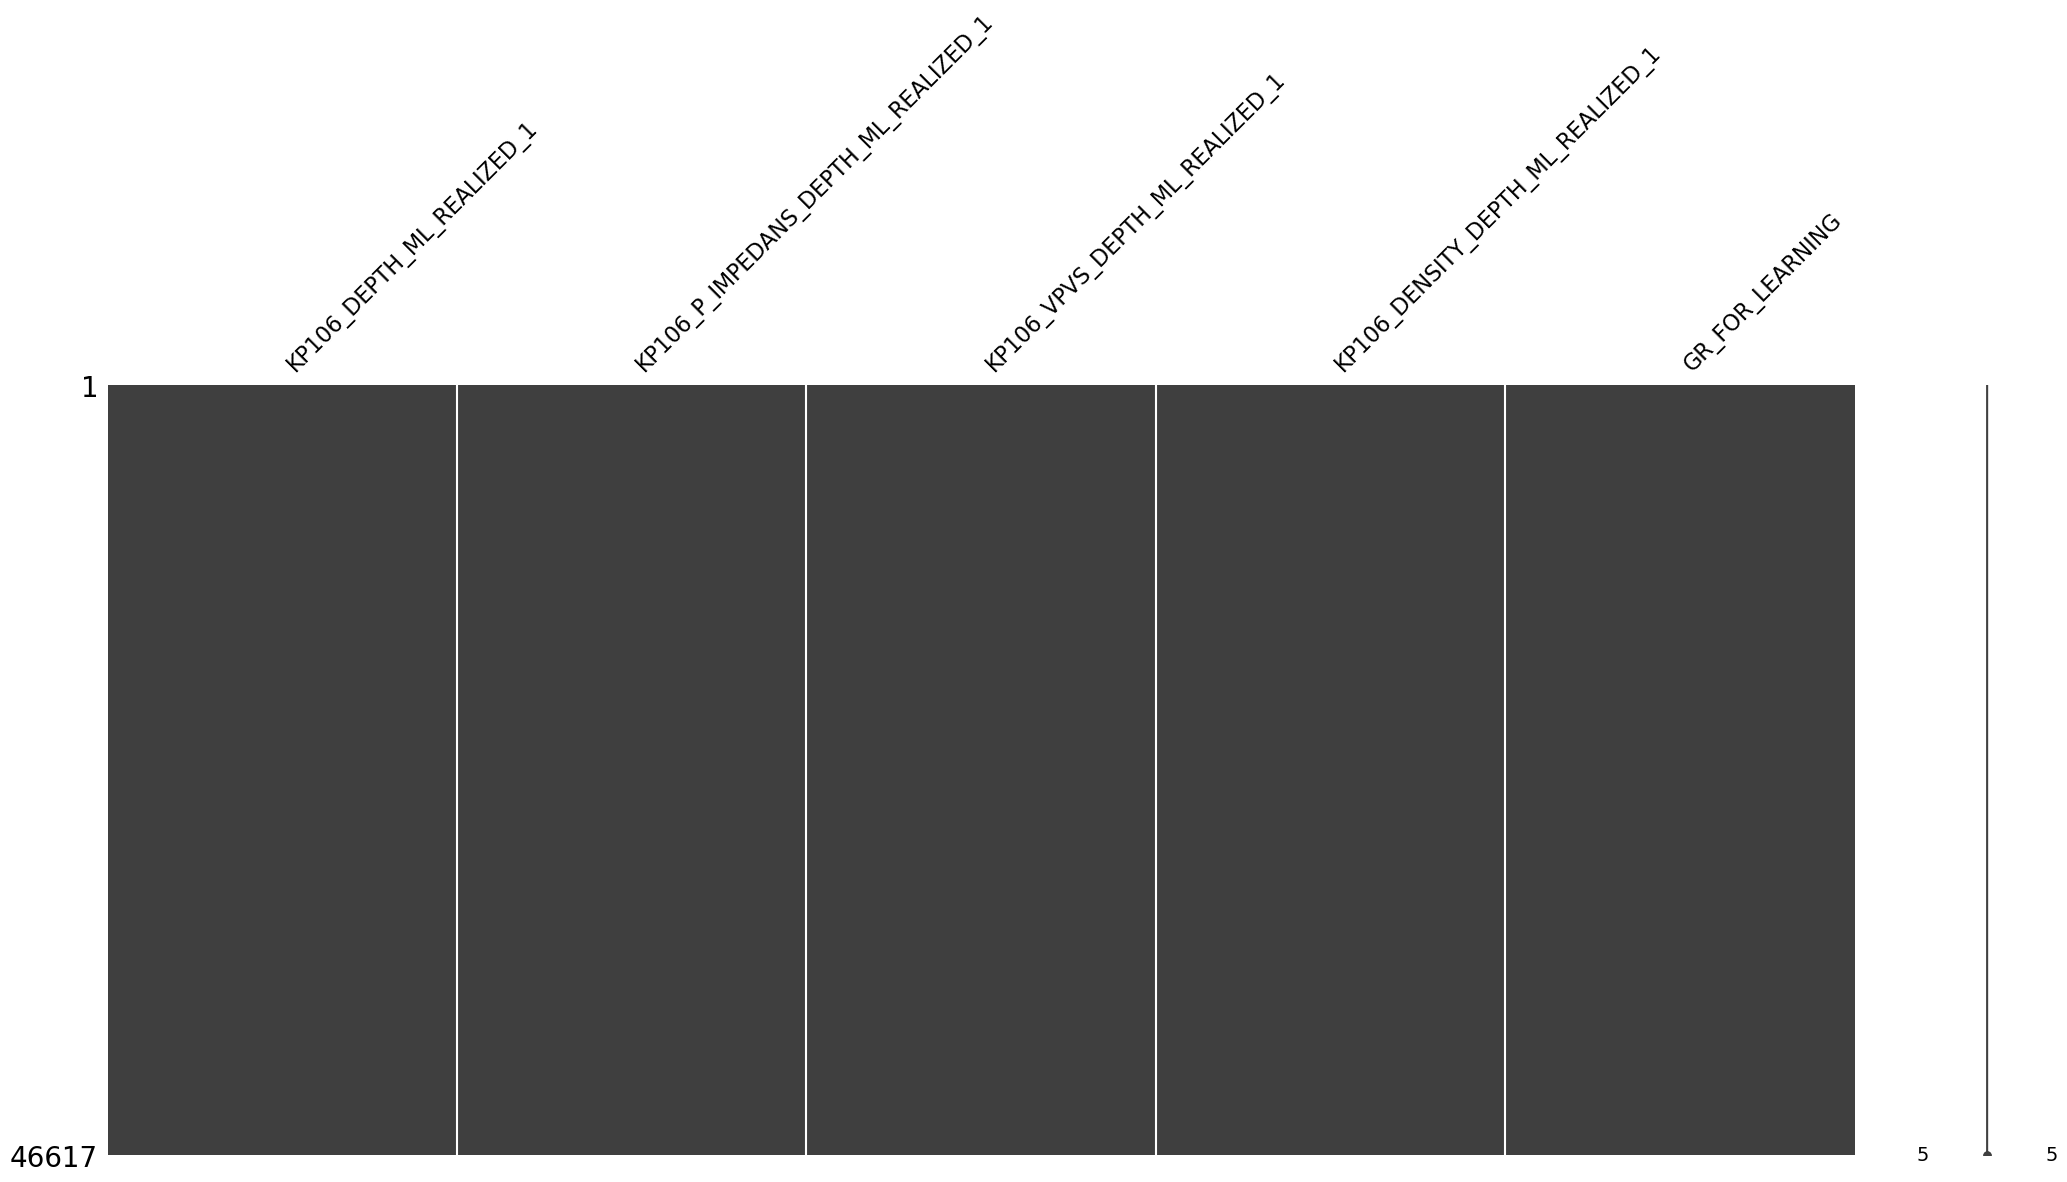

In [37]:
fig = msno.matrix(initial_data[columns_for_visualization])

In [38]:
image_basepath = r".\01.Pictures"
image_name = "initial_data.png"
date_time_str
save_fig(fig, image_name, date_time_str, 1000)

<Axes: >

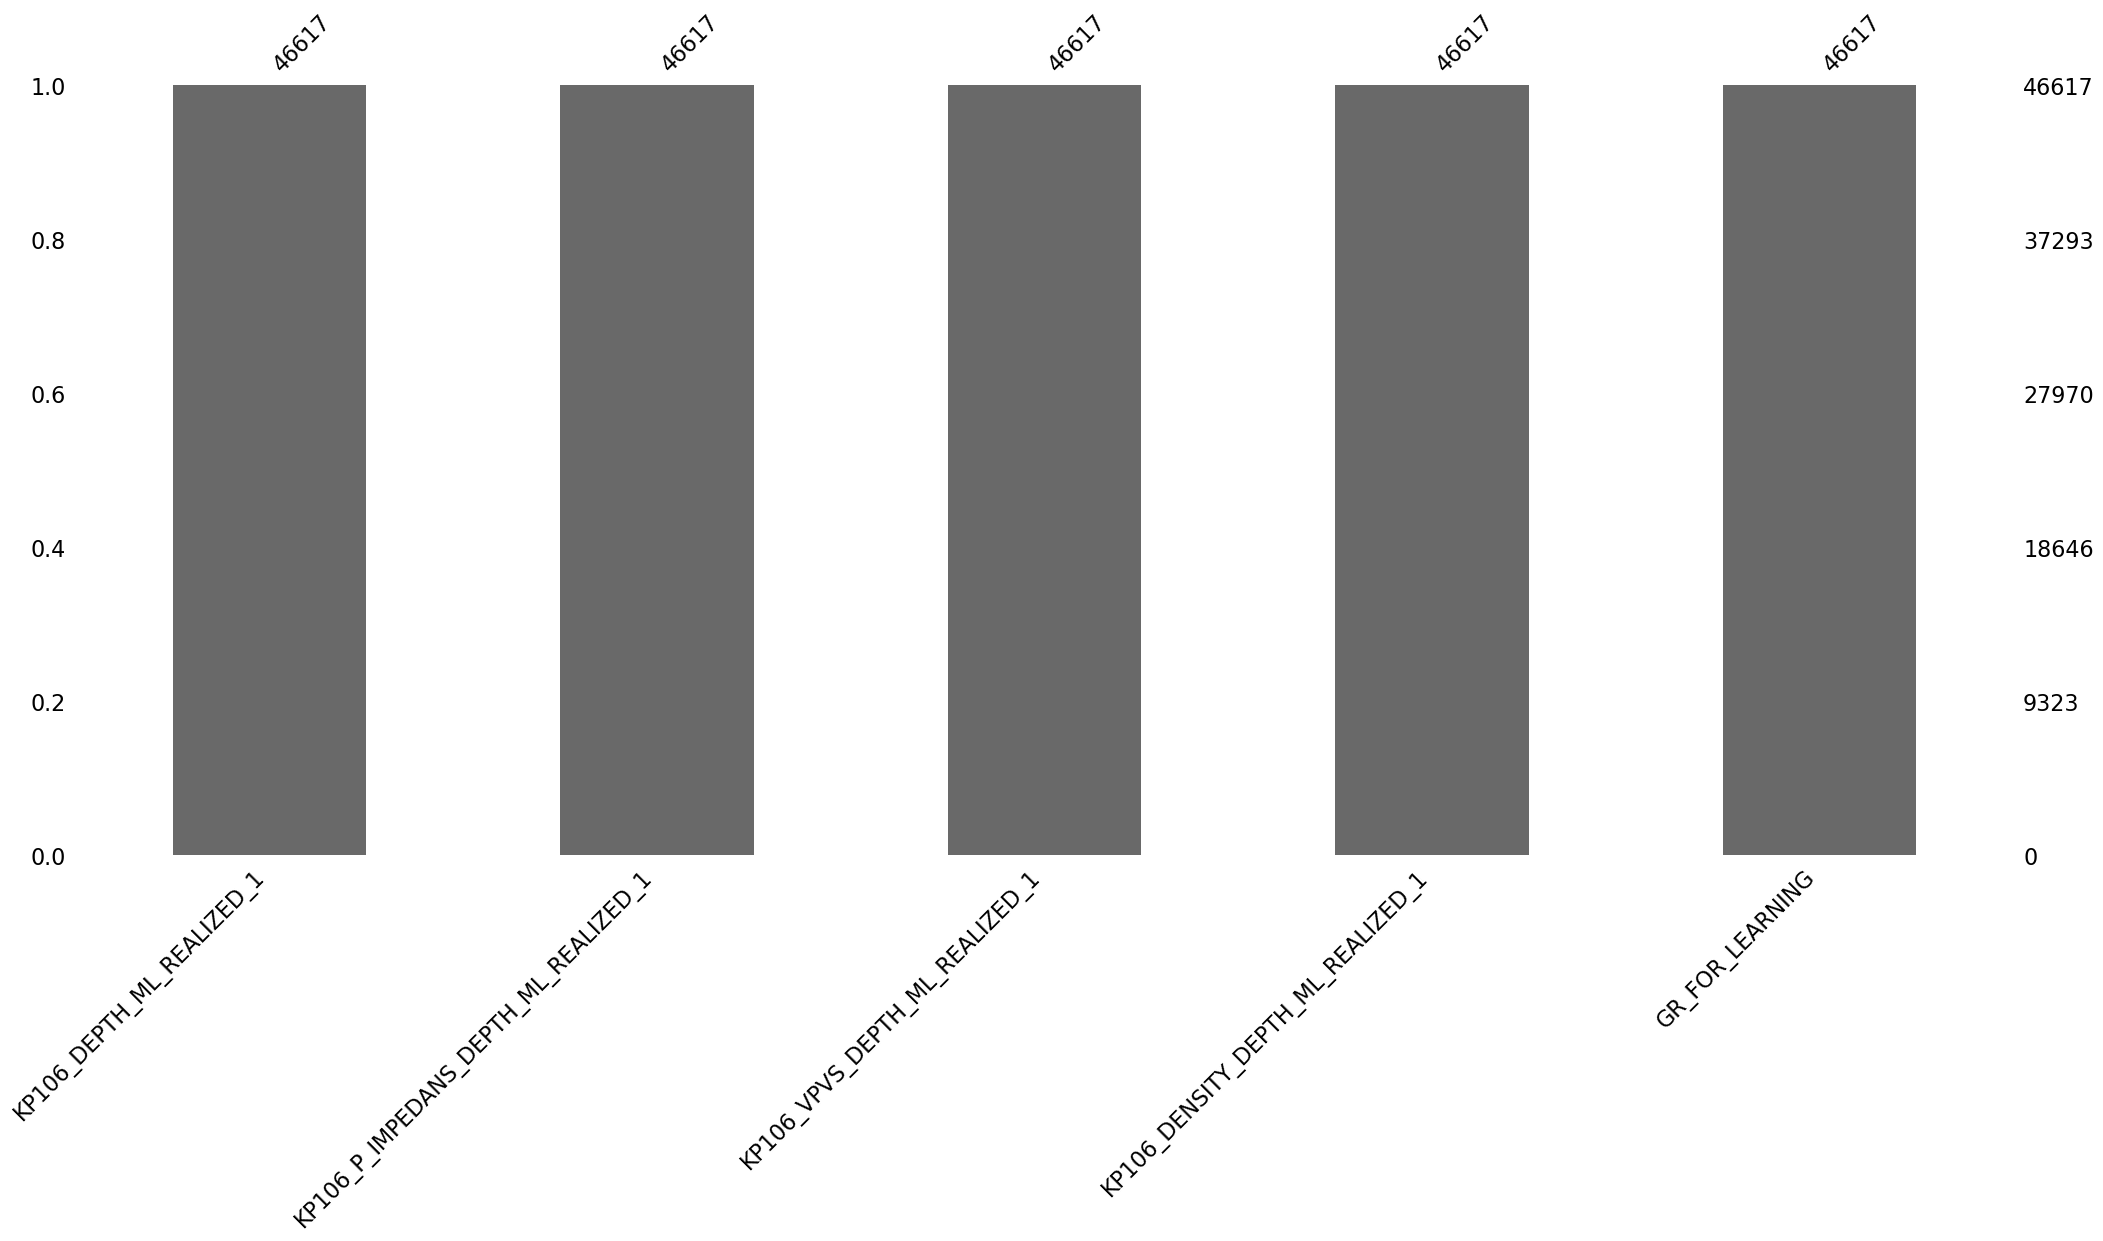

In [39]:
msno.bar(initial_data)

In [40]:
initial_data.columns

Index(['KP106_DEPTH_ML_REALIZED_1', 'KP106_P_IMPEDANS_DEPTH_ML_REALIZED_1',
       'KP106_VPVS_DEPTH_ML_REALIZED_1', 'KP106_DENSITY_DEPTH_ML_REALIZED_1',
       'GR_FOR_LEARNING'],
      dtype='object')

In [41]:
data_for_processing = initial_data

# ==============================================================

# ==============================================================

# ==============================================================

# Preparing data for the analysis

### Deleting data further that 2/3 STD

In [42]:
columns_not_to_clear = [target_column_name]
columns = data_for_processing.columns
columns_to_clear = columns.drop(columns_not_to_clear)

In [43]:
data_for_processing[columns_for_visualization].shape

(46617, 5)

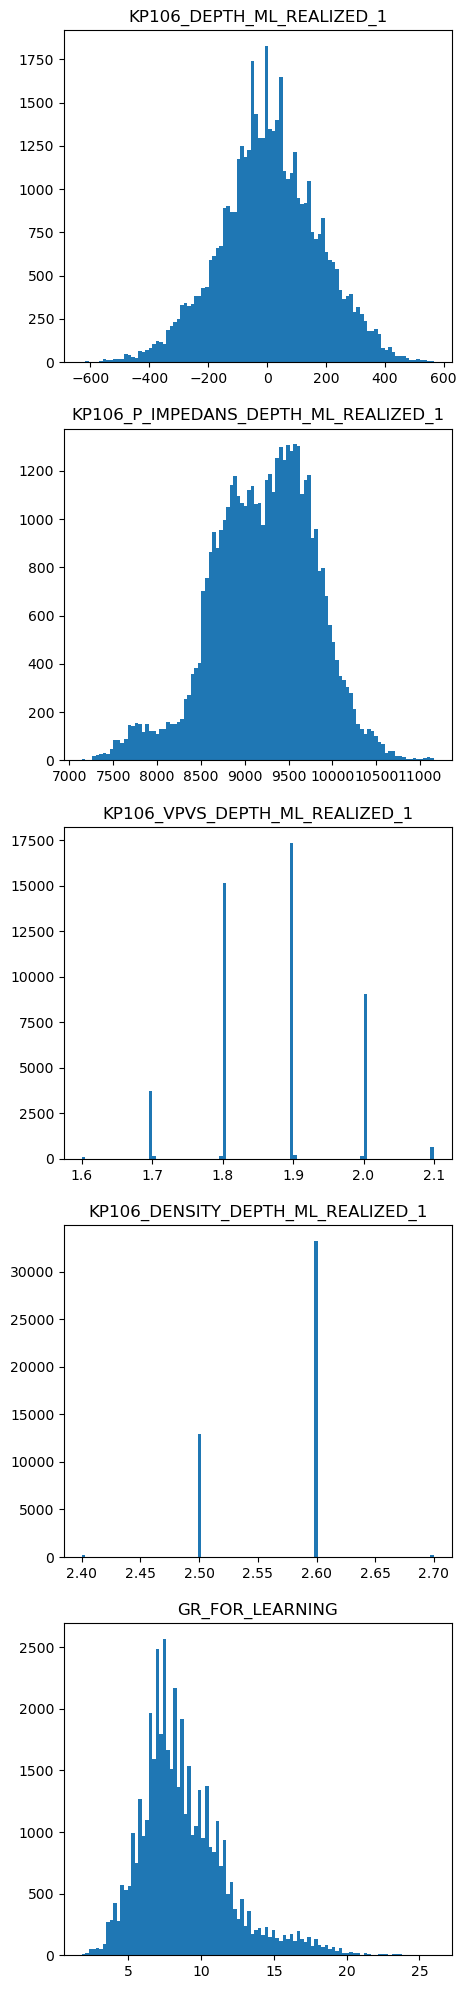

In [44]:
plot_distribs(data_for_processing[columns_for_visualization])

In [45]:
data_dropped_outliers = drop_outliers(data_for_processing, columns_to_clear, 3)

Initial df shape: (46617, 5), 
 Result df shape: (46130, 5), 
 N of dropped examples: 487


D:\Temp\ipykernel_27532\698237715.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["n_std_away"] = np.abs((df[column] - column_mean) / column_STD)


In [46]:
data_dropped_outliers.shape

(46130, 5)

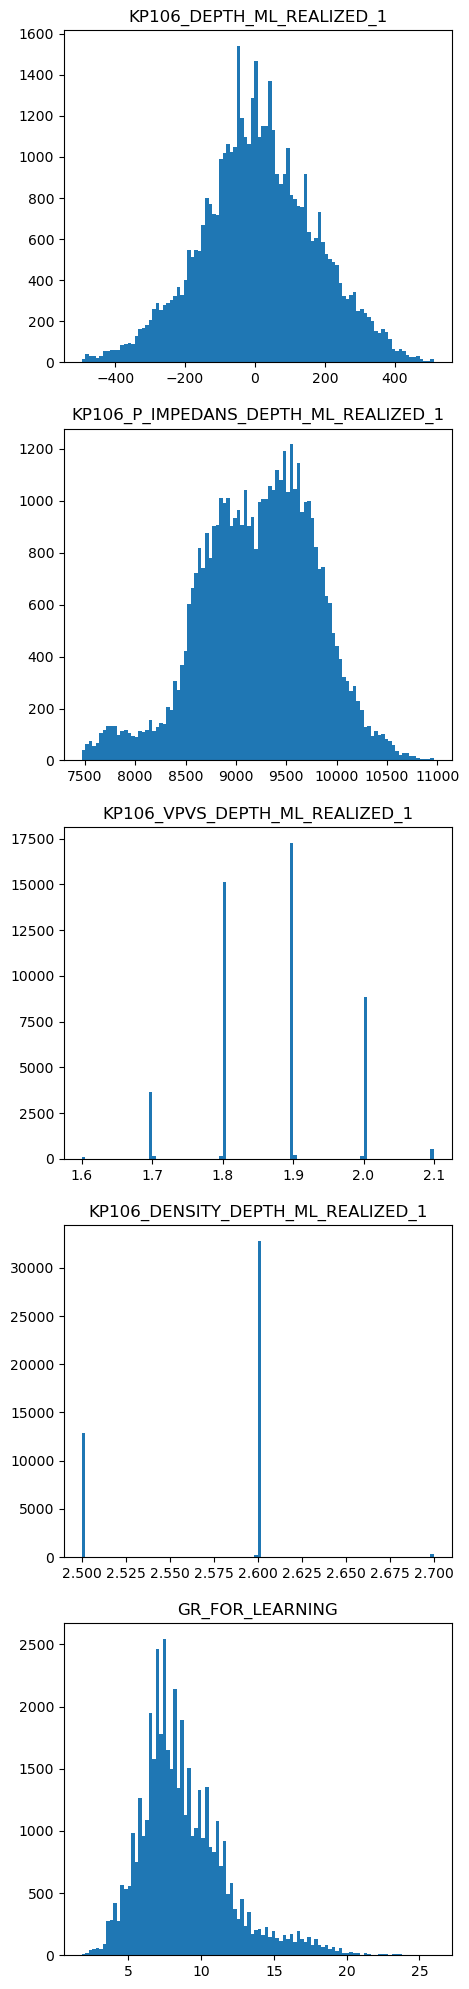

In [47]:
plot_distribs(data_dropped_outliers[columns_for_visualization])

In [48]:
data_cutted = data_dropped_outliers.copy()

### Dropping attributes with correlation > 0.8

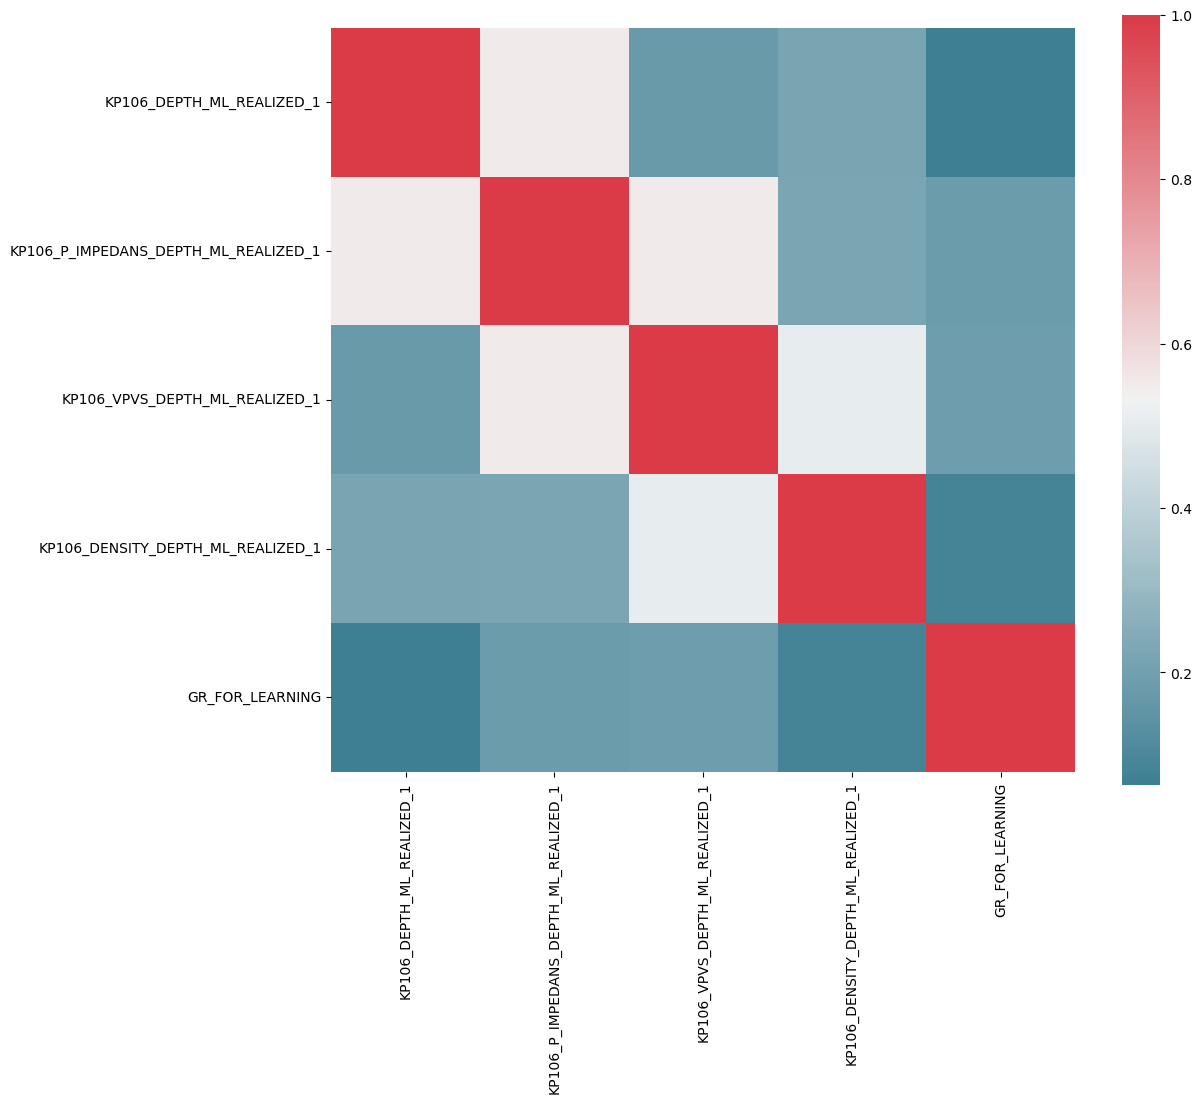

In [49]:
fig = plot_corr_heat_map(data_cutted)

In [50]:
data_dropped_correlations = drop_corr(data_cutted, corr_coef=0.8)

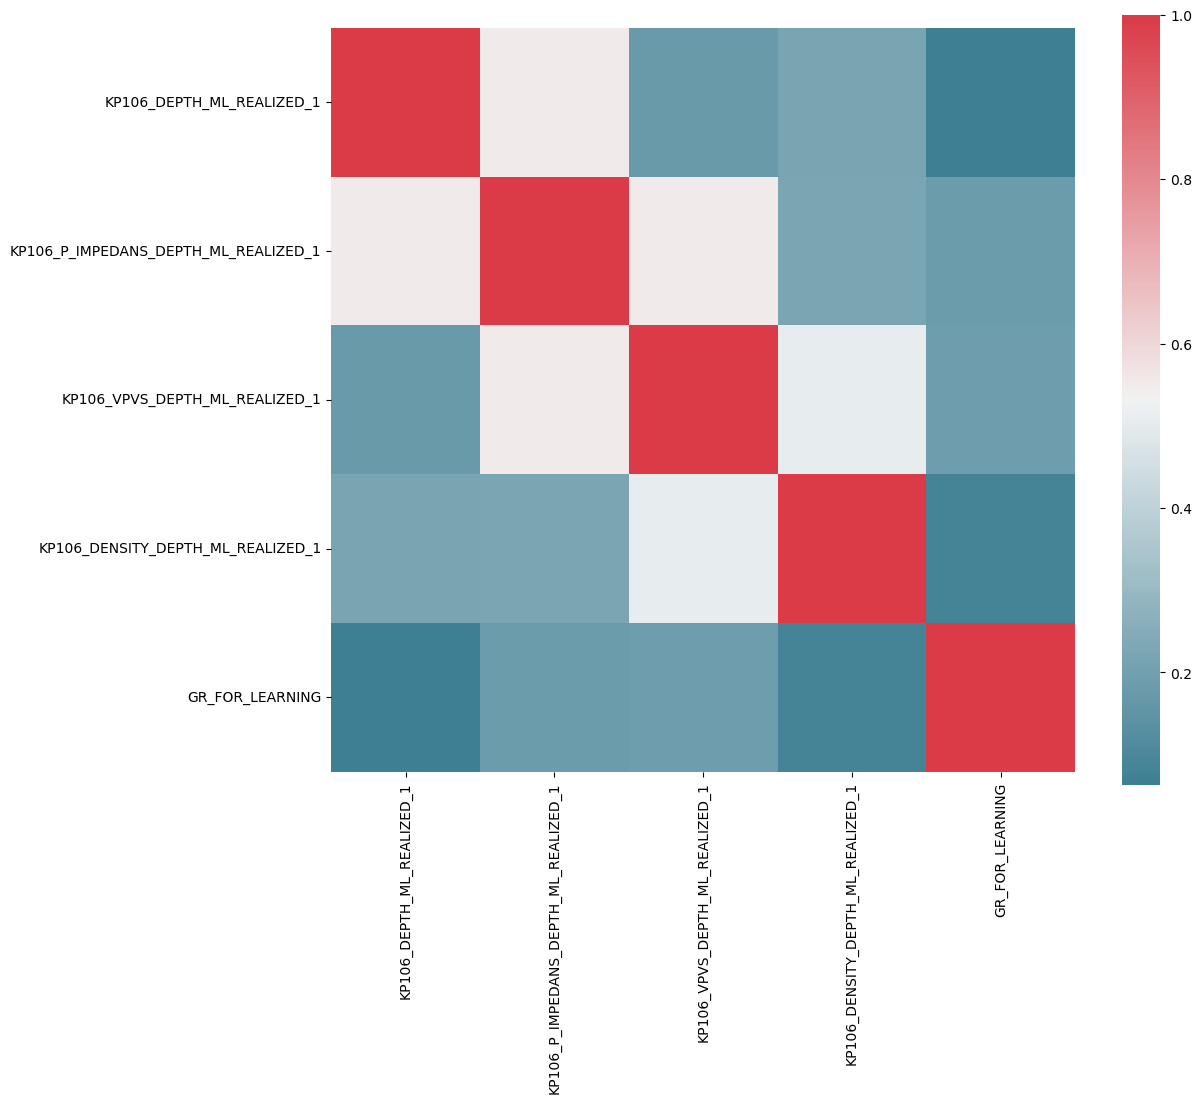

In [51]:
fig = plot_corr_heat_map(data_dropped_correlations)

### Dropping NA

In [52]:
data = data_dropped_correlations.dropna()

# ==============================================================

# ==============================================================

# ==============================================================

# Augmenting data, if needed

In [53]:
def augment_data(X, y, n_of_steps, augm_percent):

    current_augm_percent = augm_percent
    X_new = X
    Y_new = y

    for step in range (n_of_steps):
        
        X_plus = X * (1 + current_augm_percent)
        X_minus = X * (1 - current_augm_percent)

        X_new = pd.concat([X_new, X_plus, X_minus])
        Y_new = pd.concat([Y_new, y, y])

        current_augm_percent += augm_percent
    
    return X_new, Y_new

In [58]:
X = data.drop(columns=[target_column_name])
Y = data[target_column_name]

In [86]:
X_aug, Y_aug = augment_data(X, Y, 30, 0.05)

In [87]:
def add_features(X, y, add_log=True, add_exp=True, add_sqrt=True, add_square=True, add_rms=True):
    start_columns = X.columns
    
    if add_log:
        log_X_data = np.log(X[start_columns])
        log_X_data.columns = [column_name + "_log" for column_name in X[start_columns]]
        X = pd.concat([X, log_X_data], axis=1)
        X = X[X != np.NINF]
        X = X[X != np.Inf]
        
    if add_exp:
        exp_X_data = np.exp(X[start_columns])
        exp_X_data.columns = [column_name + "_exp" for column_name in X[start_columns]]
        X = pd.concat([X, exp_X_data], axis=1)
        X = X[X != np.NINF]
        X = X[X != np.Inf]
        
    if add_sqrt:
        sqrt_X_data = np.sqrt(X[start_columns])
        sqrt_X_data.columns = [column_name + "_sqrt" for column_name in X[start_columns]]
        X = pd.concat([X, sqrt_X_data], axis=1)
        X = X[X != np.NINF]
        X = X[X != np.Inf]

    if add_square:
        square_X_data = np.square(X[start_columns])
        square_X_data.columns = [column_name + "_square" for column_name in X[start_columns]]
        X = pd.concat([X, square_X_data], axis=1)
        X = X[X != np.NINF]
        X = X[X != np.Inf]

    if add_rms:
        rms_X_data = np.sqrt(np.square(X[start_columns]))
        rms_X_data.columns = [column_name + "_rms" for column_name in X[start_columns]]
        X = pd.concat([X, rms_X_data], axis=1)
        X = X[X != np.NINF]
        X = X[X != np.Inf]

    print(X.shape)
    
    mask = X.isna().any(axis=1)
    X, y = X[~mask], y[~mask]

    print(X.shape)

    return X, y

In [88]:
X_aug, Y_aug = add_features(X_aug, Y_aug, add_log=False, add_exp=False, add_sqrt=False, add_square=True, add_rms=True)

(2813930, 12)
(2813930, 12)


In [89]:
data_aug = pd.concat([X_aug, Y_aug], axis = 1)

In [90]:
data = data_aug

In [91]:
data.shape

(2813930, 13)

# Preparing Train/Val/Test test

In [92]:
train_data, test_data = train_test_split(data, test_size=0.1)

In [93]:
train_data, val_data = train_test_split(train_data, test_size=0.1)

In [94]:
X_train = train_data.drop(columns=target_column_name)
y_train = train_data[target_column_name]

X_val = val_data.drop(columns=target_column_name)
y_val = val_data[target_column_name]

X_test = test_data.drop(columns=target_column_name)
y_test = test_data[target_column_name]

In [95]:
X_train_for_columns = X_train

In [96]:
X_train.mean()

KP106_DEPTH_ML_REALIZED_1                      1.064239e+01
KP106_P_IMPEDANS_DEPTH_ML_REALIZED_1           9.225623e+03
KP106_VPVS_DEPTH_ML_REALIZED_1                 1.871846e+00
KP106_DENSITY_DEPTH_ML_REALIZED_1              2.572754e+00
KP106_DEPTH_ML_REALIZED_1_square               4.814462e+04
KP106_P_IMPEDANS_DEPTH_ML_REALIZED_1_square    1.516581e+08
KP106_VPVS_DEPTH_ML_REALIZED_1_square          6.234068e+00
KP106_DENSITY_DEPTH_ML_REALIZED_1_square       1.175270e+01
KP106_DEPTH_ML_REALIZED_1_rms                  1.412358e+02
KP106_P_IMPEDANS_DEPTH_ML_REALIZED_1_rms       1.005790e+04
KP106_VPVS_DEPTH_ML_REALIZED_1_rms             2.040690e+00
KP106_DENSITY_DEPTH_ML_REALIZED_1_rms          2.804839e+00
dtype: float64

In [97]:
save_columns_for_pred(X_train, date_time_str)

### Defining categorical and numerical attributes

In [98]:
cat_attribs = []
num_attribs = X_train.columns.drop(cat_attribs)

In [99]:
X_train.shape

(2279283, 12)

In [100]:
X_train.columns

Index(['KP106_DEPTH_ML_REALIZED_1', 'KP106_P_IMPEDANS_DEPTH_ML_REALIZED_1',
       'KP106_VPVS_DEPTH_ML_REALIZED_1', 'KP106_DENSITY_DEPTH_ML_REALIZED_1',
       'KP106_DEPTH_ML_REALIZED_1_square',
       'KP106_P_IMPEDANS_DEPTH_ML_REALIZED_1_square',
       'KP106_VPVS_DEPTH_ML_REALIZED_1_square',
       'KP106_DENSITY_DEPTH_ML_REALIZED_1_square',
       'KP106_DEPTH_ML_REALIZED_1_rms',
       'KP106_P_IMPEDANS_DEPTH_ML_REALIZED_1_rms',
       'KP106_VPVS_DEPTH_ML_REALIZED_1_rms',
       'KP106_DENSITY_DEPTH_ML_REALIZED_1_rms'],
      dtype='object')

### defining data transformation pipeline, and saving it for the future

In [101]:
full_pipeline = ColumnTransformer([ 
    ("num", StandardScaler(), num_attribs), 
    ("cat", OneHotEncoder(), cat_attribs)
])

X_train = full_pipeline.fit_transform(X_train)
X_val = full_pipeline.fit_transform(X_val)
X_test = full_pipeline.transform(X_test)

save_model(full_pipeline, date_time_str, "ColumnTransformer")

# ==============================================================

# ==============================================================

# ==============================================================

# Learning models

In [102]:
# Used for data visualization

visualization_step = 50000

## XGBRegressor

#### Stage 1 - RudeSearchOfParams

In [103]:
tree_booster_params = {
    "eta" : [0.1, 0.3, 0.5, 0.8], 
    "gamma": [10, 30, 50, 70, 90], 
    "max_depth": [8, 16, 32], 
    "alpha": [0.1, 1, 10, 50, 100, 1000]
    
}
linear_booster_params = {
    "lambda": [10, 30, 50, 70, 90], 
    "alpha": [10, 30, 50, 70, 90], 
    
}


xgb_grid_params = [
    tree_booster_params, 
    linear_booster_params,
]

xgb_grid_search = RandomizedSearchCV(XGBRegressor(), xgb_grid_params, cv=5, scoring="f1", n_iter=100, n_jobs=-1)

In [104]:
xgb_grid_search.fit(X_train, y_train)
xgb_reg = xgb_grid_search.best_estimator_

F:\NewFolder\ANACONDA\A\I\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [105]:
y_hat = xgb_reg.predict(X_test)

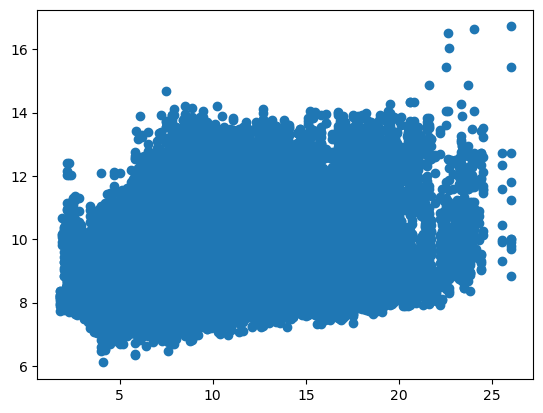

In [106]:
plt.scatter(y_test, y_hat)

In [107]:
r2_score(y_test, y_hat)

0.0945363485864209

In [108]:
errors = y_test - y_hat

(array([1.29000e+02, 4.85000e+03, 6.14730e+04, 1.22214e+05, 6.33900e+04,
        1.65800e+04, 9.42400e+03, 2.71500e+03, 5.66000e+02, 5.20000e+01]),
 array([-10.2114666 ,  -7.47414314,  -4.73681969,  -1.99949623,
          0.73782722,   3.47515068,   6.21247414,   8.94979759,
         11.68712105,  14.4244445 ,  17.16176796]),
 <BarContainer object of 10 artists>)

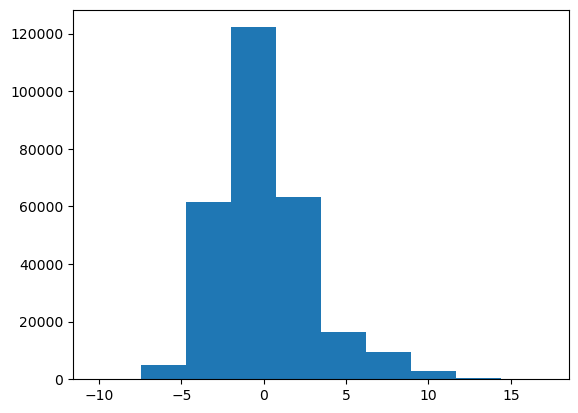

In [109]:
plt.hist(errors)

In [110]:
save_model(xgb_reg, date_time_str, "xgb_reg_stage1")

Current_data_lenth: 29283
Current_data_lenth: 79283
Current_data_lenth: 129283
Current_data_lenth: 179283
Current_data_lenth: 229283
Current_data_lenth: 279283
Current_data_lenth: 329283
Current_data_lenth: 379283
Current_data_lenth: 429283
Current_data_lenth: 479283
Current_data_lenth: 529283
Current_data_lenth: 579283
Current_data_lenth: 629283
Current_data_lenth: 679283
Current_data_lenth: 729283
Current_data_lenth: 779283
Current_data_lenth: 829283
Current_data_lenth: 879283
Current_data_lenth: 929283
Current_data_lenth: 979283
Current_data_lenth: 1029283
Current_data_lenth: 1079283
Current_data_lenth: 1129283
Current_data_lenth: 1179283
Current_data_lenth: 1229283
Current_data_lenth: 1279283
Current_data_lenth: 1329283
Current_data_lenth: 1379283
Current_data_lenth: 1429283
Current_data_lenth: 1479283
Current_data_lenth: 1529283
Current_data_lenth: 1579283
Current_data_lenth: 1629283
Current_data_lenth: 1679283
Current_data_lenth: 1729283
Current_data_lenth: 1779283
Current_data_l

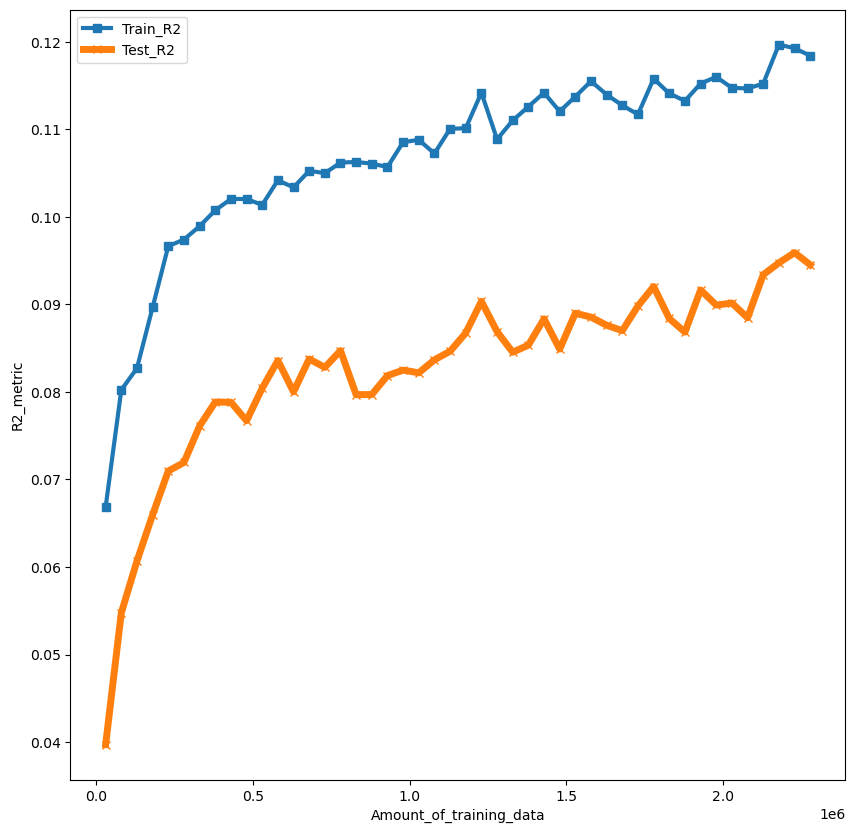

In [111]:
plot_data_amount_tendency_reg(xgb_reg, X_train, y_train, X_test, y_test, step=visualization_step)

#### Stage 2 - OptimizingBestParams

In [276]:
# Searching better parameters set around the one found in Stage 1

tree_booster_params = {
    "eta" : np.arange(0.1, 0.55, 0.05), 
    "gamma": np.arange(1, 30, 1, dtype = int), 
    "max_depth": np.linspace(8, 32, 1, dtype=int),
}

fit_params = {"early_stopping_rounds": 10, 
              "eval_metric": "aucpr", 
              "eval_set": [[X_val, y_val]]}
xgb_grid_search = RandomizedSearchCV(XGBRegressor(), tree_booster_params, 
                                     n_iter=100, n_jobs=20, random_state=42)

In [277]:
xgb_grid_search.fit(X_train, y_train, **fit_params)
xgb_reg_stage2 = xgb_grid_search.best_estimator_

[0]	validation_0-aucpr:nan
[1]	validation_0-aucpr:nan
[2]	validation_0-aucpr:nan
[3]	validation_0-aucpr:nan
[4]	validation_0-aucpr:nan
[5]	validation_0-aucpr:nan
[6]	validation_0-aucpr:nan
[7]	validation_0-aucpr:nan
[8]	validation_0-aucpr:nan
[9]	validation_0-aucpr:nan
[10]	validation_0-aucpr:nan


F:\NewFolder\ANACONDA\A\I\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
F:\NewFolder\ANACONDA\A\I\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
F:\NewFolder\ANACONDA\A\I\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\metric\auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


In [278]:
xgb_reg_stage2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.5000000000000001, eval_metric=None,
             feature_types=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [279]:
y_hat = xgb_reg_stage2.predict(X_test)

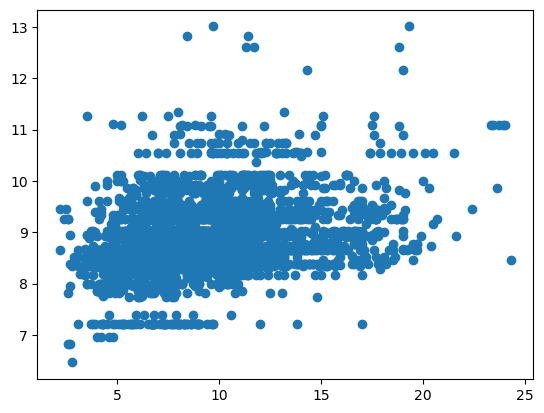

In [280]:
plt.scatter(y_test, y_hat)

In [281]:
r2_score(y_test, y_hat)

0.09108265330241971

(array([  24.,  460., 1671., 1355.,  696.,  203.,  141.,   51.,   10.,
           2.]),
 array([-7.76535225, -5.40510933, -3.04486641, -0.68462349,  1.67561943,
         4.03586235,  6.39610527,  8.75634819, 11.11659111, 13.47683403,
        15.83707695]),
 <BarContainer object of 10 artists>)

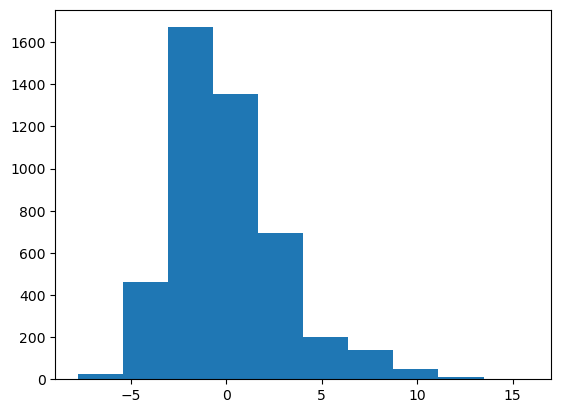

In [282]:
errors = y_test - y_hat
plt.hist(errors)

In [283]:
save_model(xgb_reg, date_time_str, "xgb_reg_stage2")

Current_data_lenth: 1365
Current_data_lenth: 3365
Current_data_lenth: 5365
Current_data_lenth: 7365
Current_data_lenth: 9365
Current_data_lenth: 11365
Current_data_lenth: 13365
Current_data_lenth: 15365
Current_data_lenth: 17365
Current_data_lenth: 19365
Current_data_lenth: 21365
Current_data_lenth: 23365
Current_data_lenth: 25365
Current_data_lenth: 27365
Current_data_lenth: 29365
Current_data_lenth: 31365
Current_data_lenth: 33365
Current_data_lenth: 35365
Current_data_lenth: 37365


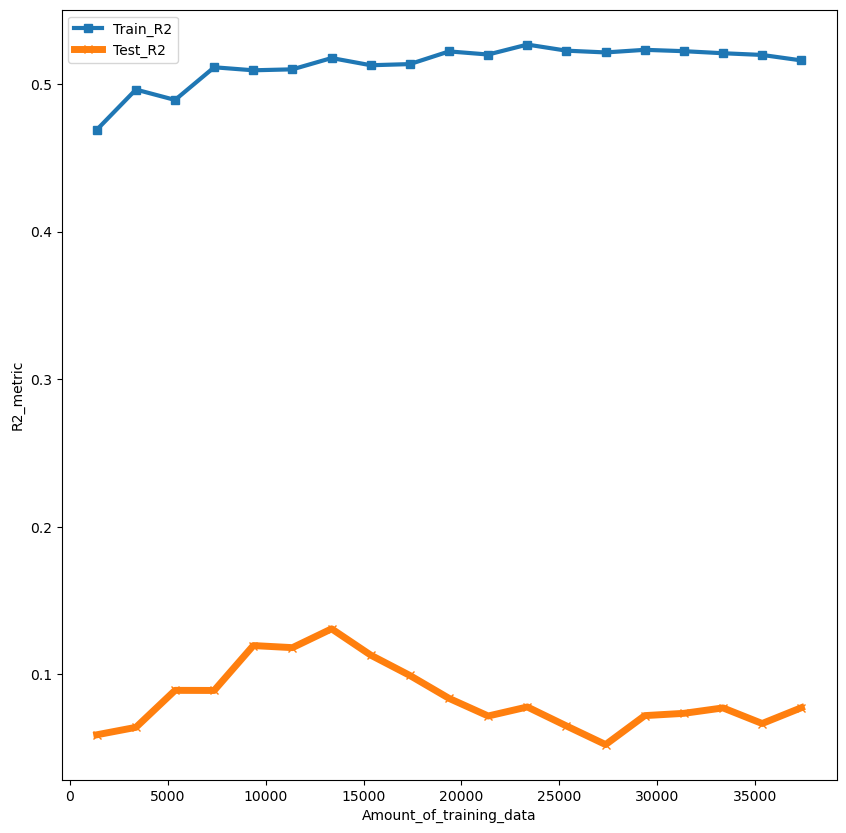

In [288]:
plot_data_amount_tendency_reg(xgb_reg, X_train, y_train, X_test, y_test, step=visualization_step)

##  MLPClassifier

Many classifiers seems to work well on this dataset, so let's try to train some more, if they'll work as well, we can try to add them to VotingClassifier

In [153]:
mlp_params_grid = {
    "solver": ["lbfgs", "sgd", "adam"],
    "hidden_layer_sizes": [(300, 2), (300, 3), (300, 4), (300, 5), (300, 6)],
    "alpha": [0.0001, 0.01, 1],
    "random_state": [42],
    "activation": ["identity", "logistic", "tanh", "relu"],
}


mlp_rand_search = RandomizedSearchCV(MLPRegressor(), mlp_params_grid, cv=5, scoring="f1", n_jobs=-1, n_iter=30)

In [154]:
mlp_rand_search.fit(X_train, y_train)
mlp_reg = mlp_rand_search.best_estimator_

F:\NewFolder\ANACONDA\A\I\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [155]:
y_hat = mlp_reg.predict(X_test)

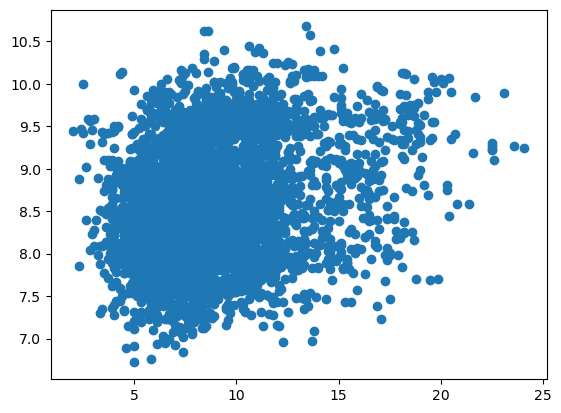

In [156]:
plt.scatter(y_test, y_hat)

In [157]:
r2_score(y_test, y_hat)

0.04745643789954512

(array([  31.,  421., 1527., 1384.,  747.,  224.,  161.,   94.,   15.,
           9.]),
 array([-7.49469289, -5.25966102, -3.02462914, -0.78959727,  1.4454346 ,
         3.68046648,  5.91549835,  8.15053023, 10.3855621 , 12.62059397,
        14.85562585]),
 <BarContainer object of 10 artists>)

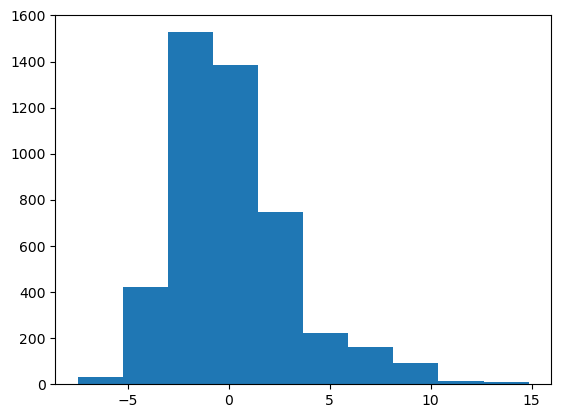

In [158]:
errors = y_test - y_hat
plt.hist(errors)

In [159]:
save_model(mlp_reg, date_time_str, "mlp_reg")

Current_data_lenth: 1365
Current_data_lenth: 3365
Current_data_lenth: 5365
Current_data_lenth: 7365
Current_data_lenth: 9365
Current_data_lenth: 11365
Current_data_lenth: 13365
Current_data_lenth: 15365
Current_data_lenth: 17365
Current_data_lenth: 19365
Current_data_lenth: 21365
Current_data_lenth: 23365
Current_data_lenth: 25365
Current_data_lenth: 27365
Current_data_lenth: 29365
Current_data_lenth: 31365
Current_data_lenth: 33365
Current_data_lenth: 35365
Current_data_lenth: 37365


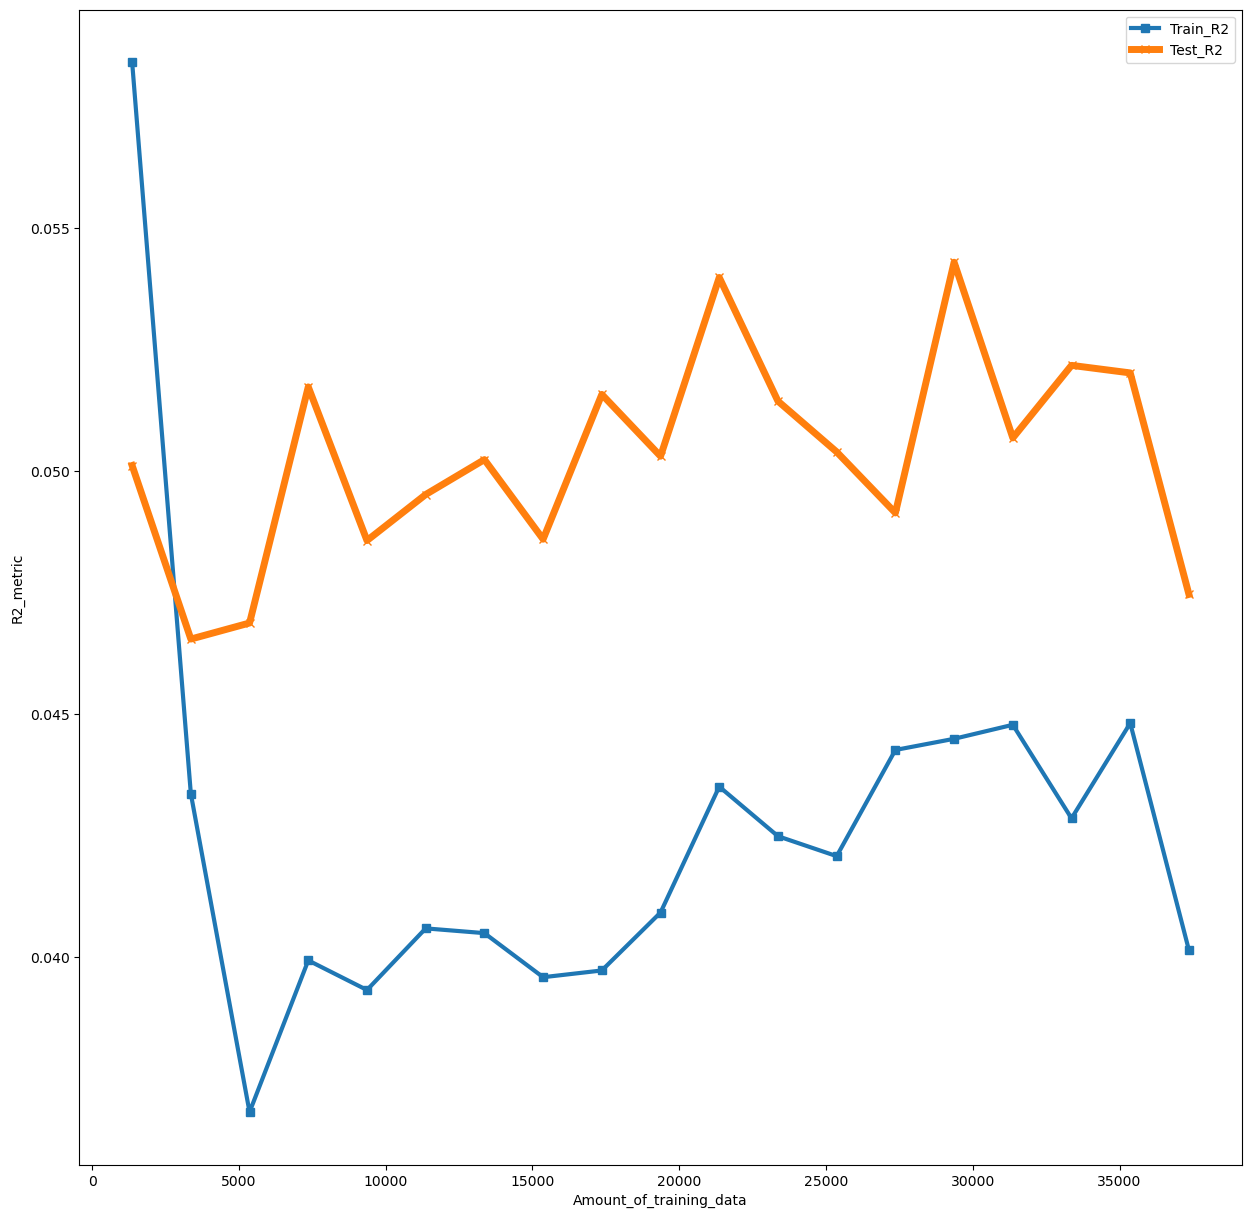

In [171]:
plot_data_amount_tendency_reg(mlp_reg, X_train, y_train, X_test, y_test, step=visualization_step)